<a href="https://colab.research.google.com/github/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLIP Explainability**

In [1]:
import os

os.chdir(f'./Transformer-MM-Explainability')
# !pip install einops
# !pip install ftfy
# !pip install captum

# **CLIP**

In [2]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization
import warnings

warnings.filterwarnings('ignore')

In [3]:
from utils import interpret, show_img_heatmap, show_txt_heatmap

In [4]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
}

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [6]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

tensor([0.0276, 0.0648, 0.0048, 0.1705, 0.7324], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with eye glasses


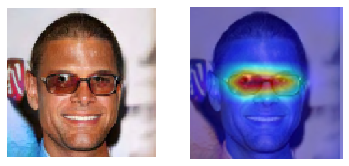

tensor([0.0355, 0.0699, 0.0015, 0.0647, 0.8286], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with white teeth


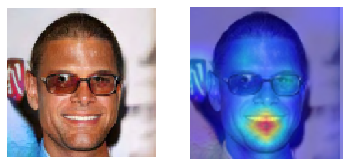

tensor([0.4397, 0.4900, 0.0297, 0.0406, 0.0000], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with a nose


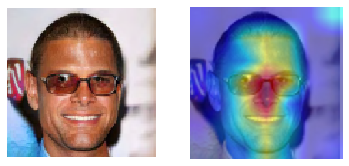

In [14]:
def show_cam(mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap
    cam = cam / np.max(cam)
    return cam


def interpret_and_generate(model, img, texts, orig_image):
    text = clip.tokenize(texts).to(device)
    R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
    batch_size = text.shape[0]

    for i in range(batch_size):
        text_scores = show_txt_heatmap(texts[i], text[i], R_text[i])
        image_relevance = show_img_heatmap(R_image[i], img, orig_image=orig_image)
#         image_relevance = show_cam(image_relevance)
#         plt.imshow(image_relevance)
#         print(text_scores)
        plt.show()


texts = ["a man with eyeglasses", "a man with white teeth", "a man with a nose"]
img_path = "CLIP/glasses.png"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
interpret_and_generate(model, img, texts, Image.open(img_path))

In [8]:
from utils import load_dataset

data = load_dataset()

7
dict_keys(['image', 'text', 'image_mask', 'text_mask'])
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x426 at 0x7F78207F02D0>
['In this', 'image', 'a', 'bed', 'is visible on which', 'two dogs', 'and', 'cat', 'are sleeping,', 'cushions', 'and', 'blankets', 'are visible and', 'book', 'visible.', 'background walls', 'are white in', 'color', 'and a', 'curtain', 'visible and a', 'table', 'visible. this', 'image', 'is taken inside a', 'room', '.']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


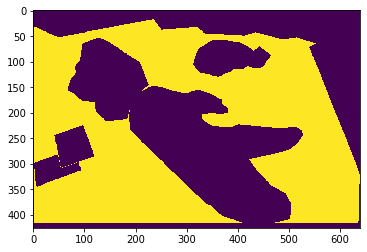

In [9]:
print(len(data))
print(data[0].keys())
print(data[0]['image'])
print(data[0]['text'])
print(data[0]['image_mask'])
print(data[0]['text_mask'])

plt.imshow(data[0]['image_mask'])
plt.show()

In [71]:
def center_crop(im: Image):
    width, height = im.size
    new_width = width if width < height else height
    new_height = height if height < width else width 

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    
    return im

def pad_to_square(im: Image):
    width, height = im.size

    vert_pad = (max(width, height) - height) // 2
    hor_pad = (max(width, height) - width) // 2
    
    return add_margin(im, vert_pad, hor_pad, vert_pad, hor_pad)
    
def add_margin(pil_img, top, right, bottom, left, color=(0, 0, 0)):
    """Ref: https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/"""
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [45]:
def process_entry(entry):
    image = entry['image']
    text_mask = entry['text_mask']
    text = entry['text']
    orig_image = pad_to_square(image)
    
    img = preprocess(orig_image).unsqueeze(0).to(device)
    text_index = text_mask.argmax()
    texts = [text[text_index]]
    
    return img, texts, orig_image

640 426
107 0
tensor([1.], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,bed


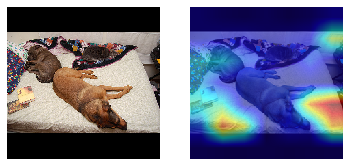

640 426
107 0
tensor([0.0398, 0.9604], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,two dogs


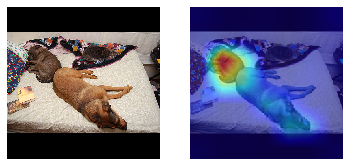

640 426
107 0
tensor([1.], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,cat


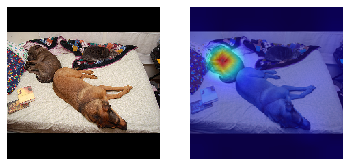

640 426
107 0
tensor([1.], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,cushions


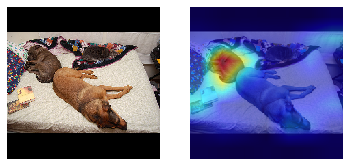

640 426
107 0
tensor([1.], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,blankets


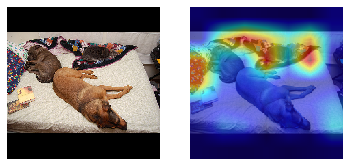

640 426
107 0
tensor([1.], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,book


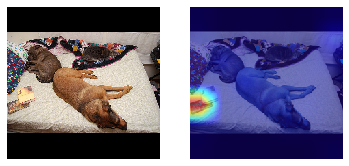

640 426
107 0
tensor([0.8120, 0.1877], device='cuda:0', dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,background walls


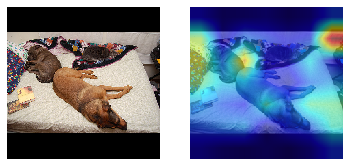

In [47]:
for entry in data:
    test_img, test_texts, orig_image = process_entry(entry)
    interpret_and_generate(model, test_img, test_texts, orig_image)

In [75]:
def process_entry_image_to_text(entry):
    mask = np.repeat(np.expand_dims(entry['image_mask'], -1), 3, axis=-1)
    masked_image = (mask * np.asarray(entry['image'])).astype(np.uint8)
    masked_image = Image.fromarray(masked_image)
    texts = [' '.join(entry['text'])]
    orig_image = pad_to_square(masked_image)
    img = preprocess(orig_image).unsqueeze(0).to(device)
    
    return img, texts, orig_image
    
#     image = entry['image']
#     text_mask = entry['text_mask']
#     text = entry['text']
#     orig_image = pad_to_square(image)
    
#     img = preprocess(orig_image).unsqueeze(0).to(device)
#     text_index = text_mask.argmax()
#     texts = [text[text_index]]
    
#     return img, texts, orig_image
# entry = data[1]

tensor([0.0012, 0.0010, 0.0095, 0.0000, 0.0333, 0.0213, 0.0381, 0.0094, 0.0014,
        0.0047, 0.0090, 0.0035, 0.0171, 0.0007, 0.0456, 0.0000, 0.0108, 0.0055,
        0.0602, 0.0035, 0.0419, 0.0065, 0.0160, 0.0603, 0.0267, 0.0305, 0.0156,
        0.0087, 0.0983, 0.0071, 0.0767, 0.0004, 0.0006, 0.0950, 0.0700, 0.0004,
        0.0005, 0.0251, 0.0228, 0.0025, 0.0027, 0.0640, 0.0007, 0.0027, 0.0167,
        0.0014, 0.0117, 0.0184], device='cuda:0', dtype=torch.float16)


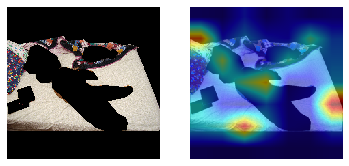

tensor([9.5129e-04, 3.8314e-04, 3.2578e-03, 9.9957e-05, 0.0000e+00, 0.0000e+00,
        1.9255e-03, 0.0000e+00, 6.8665e-05, 1.2712e-03, 4.3726e-01, 2.8656e-02,
        2.2491e-02, 3.7537e-03, 9.8328e-02, 6.7200e-02, 7.4997e-03, 1.6031e-03,
        1.1673e-02, 1.2417e-03, 8.4076e-03, 8.4066e-04, 2.4471e-03, 3.0441e-03,
        2.6722e-03, 2.7924e-03, 2.2079e-02, 2.8586e-04, 4.5776e-02, 7.2212e-03,
        4.9377e-02, 7.1669e-04, 4.2868e-04, 4.0527e-02, 3.5217e-02, 1.2083e-03,
        3.5453e-04, 6.3896e-04, 1.0780e-02, 4.3602e-03, 1.7939e-03, 4.2725e-02,
        3.9196e-04, 2.4700e-04, 9.1019e-03, 1.1861e-04, 9.1171e-03, 9.9564e-03],
       device='cuda:0', dtype=torch.float16)


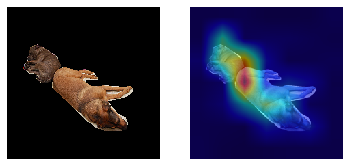

tensor([1.0796e-03, 5.1451e-04, 3.0670e-03, 1.0902e-02, 1.3786e-02, 7.4196e-04,
        3.5095e-02, 5.4626e-03, 4.7989e-03, 7.8821e-04, 3.4576e-02, 1.1345e-02,
        7.6416e-02, 9.0179e-03, 9.6313e-02, 5.1117e-02, 3.8116e-02, 1.6367e-04,
        1.8911e-03, 1.1140e-04, 1.4839e-02, 6.3562e-04, 1.2299e-02, 2.6657e-02,
        0.0000e+00, 2.6840e-02, 4.0741e-02, 1.7443e-03, 1.8420e-01, 3.4607e-02,
        2.6642e-02, 1.6575e-03, 1.7917e-04, 2.8931e-02, 7.6965e-02, 2.5558e-03,
        4.6015e-04, 3.9291e-03, 3.2532e-02, 7.4959e-03, 1.4820e-03, 3.3569e-02,
        5.4407e-04, 4.0579e-04, 8.4152e-03, 1.2960e-03, 1.9531e-02, 1.5640e-02],
       device='cuda:0', dtype=torch.float16)


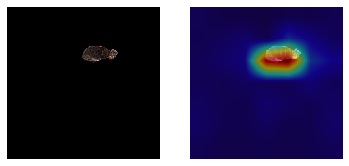

tensor([0.0012, 0.0010, 0.0095, 0.0000, 0.0333, 0.0213, 0.0381, 0.0094, 0.0014,
        0.0047, 0.0090, 0.0035, 0.0171, 0.0007, 0.0456, 0.0000, 0.0108, 0.0055,
        0.0602, 0.0035, 0.0419, 0.0065, 0.0160, 0.0603, 0.0267, 0.0305, 0.0156,
        0.0087, 0.0983, 0.0071, 0.0767, 0.0004, 0.0006, 0.0950, 0.0700, 0.0004,
        0.0005, 0.0251, 0.0228, 0.0025, 0.0027, 0.0640, 0.0007, 0.0027, 0.0167,
        0.0014, 0.0117, 0.0184], device='cuda:0', dtype=torch.float16)


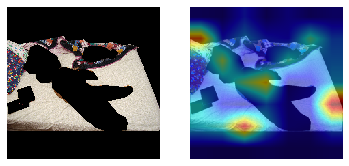

tensor([0.0012, 0.0010, 0.0095, 0.0000, 0.0333, 0.0213, 0.0381, 0.0094, 0.0014,
        0.0047, 0.0090, 0.0035, 0.0171, 0.0007, 0.0456, 0.0000, 0.0108, 0.0055,
        0.0602, 0.0035, 0.0419, 0.0065, 0.0160, 0.0603, 0.0267, 0.0305, 0.0156,
        0.0087, 0.0983, 0.0071, 0.0767, 0.0004, 0.0006, 0.0950, 0.0700, 0.0004,
        0.0005, 0.0251, 0.0228, 0.0025, 0.0027, 0.0640, 0.0007, 0.0027, 0.0167,
        0.0014, 0.0117, 0.0184], device='cuda:0', dtype=torch.float16)


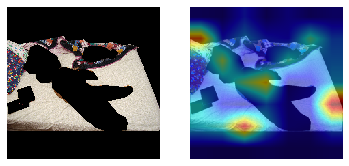

tensor([0.0018, 0.0022, 0.0113, 0.0220, 0.0244, 0.0306, 0.0678, 0.0555, 0.0110,
        0.0023, 0.0088, 0.0005, 0.0058, 0.0099, 0.0051, 0.0031, 0.0050, 0.0085,
        0.0128, 0.0027, 0.0225, 0.0083, 0.0307, 0.0353, 0.0324, 0.0245, 0.0240,
        0.0010, 0.0727, 0.0289, 0.0606, 0.0044, 0.0014, 0.0181, 0.1200, 0.0044,
        0.0010, 0.0003, 0.0551, 0.0062, 0.0012, 0.0787, 0.0010, 0.0010, 0.0081,
        0.0003, 0.0361, 0.0304], device='cuda:0', dtype=torch.float16)


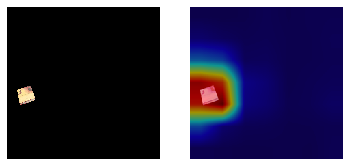

tensor([3.9005e-04, 3.7169e-04, 6.1989e-03, 1.0292e-02, 1.5259e-02, 4.7798e-03,
        4.6387e-02, 3.5950e-02, 1.1620e-02, 4.5929e-03, 2.2079e-02, 6.6817e-05,
        4.1595e-02, 3.8552e-04, 7.4997e-03, 1.3075e-03, 2.3254e-02, 6.5041e-03,
        2.4857e-02, 5.0163e-03, 2.7786e-02, 1.1963e-02, 2.9984e-02, 4.6631e-02,
        4.3854e-02, 3.3295e-02, 4.7577e-02, 6.2943e-04, 8.9539e-02, 1.0468e-02,
        4.8599e-03, 1.4794e-04, 4.3726e-04, 1.3477e-01, 6.4758e-02, 2.0275e-03,
        8.8978e-04, 1.6832e-03, 2.3727e-02, 3.9749e-03, 1.7080e-03, 6.0211e-02,
        8.0347e-04, 2.3632e-03, 1.6815e-02, 2.7103e-03, 1.5373e-02, 5.2521e-02],
       device='cuda:0', dtype=torch.float16)


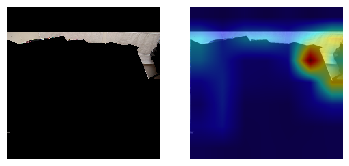

In [76]:
for entry in data:
    img, texts, orig_image = process_entry_image_to_text(entry)
    interpret_and_generate(model, img, texts, orig_image)